# Examples of Temporal Wasserstein Imputation implementations

This notebook contains examples which use the codes in the `WI_util.py` file to implement the Temporal Wasserstein Imputation (TWI) in Python.

## 1 Scalar time series with no side information

We first consider the case where $x_{t}$ is a 1-dimensional series with missing entries, and there is no side information available. As a concrete example, suppose $x_{t}$ follows the threshold AR (TAR(1)) model:

\begin{align*}
    x_{t} = \left\{ \begin{array}{cc}
        -2 x_{t-1} + \epsilon_{t},   &  x_{t-1} \leq 1\\
        0.7 x_{t-1} + 0.5\epsilon_{t},   &  x_{t-1} > 1
   \end{array} \right. .
\end{align*}

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import WI_util as WI

np.random.seed(500)

In [16]:
x = np.zeros((1100, 1))
for i in range(1, 1100):
    if x[i - 1, 0] <= 1:
        x[i] = -2 * x[i - 1] + np.random.normal(size = 1, scale = 1)
    else:
        x[i] = 0.7 * x[i - 1] + np.random.normal(size = 1, scale = 0.5)
x = x[100:]

Suppose the data we observed contains 30\% of randomly omitted data. The figure below is the time plot of the observed $x_{t}$. 

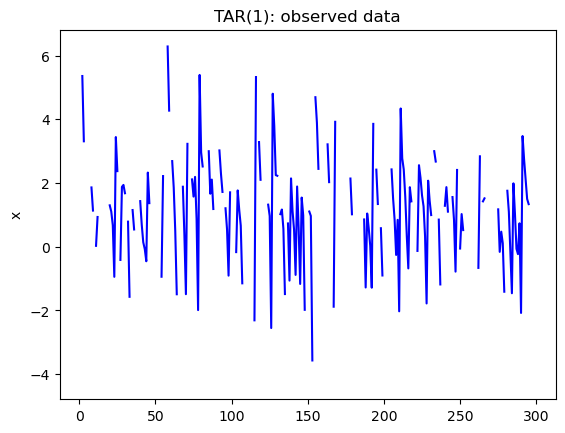

In [17]:
x_obs = x
x_obs[np.random.choice(1000, size = 300, replace = False),0] = None

plt.plot(x_obs[:300], 'b')  
plt.title("TAR(1): observed data")
plt.xlabel("")
plt.ylabel("x")
plt.show()

In this case (no side information), a fast solver `solver_ordinary` is built to solve step (b) of the alternating minimization when 2-Wasserstein distance is employed; see Huang et al. (2025) `solver_ordinary` implements the proximal gradient descent, and in this case the projection step is easy to compute.
The core function to call is `WI_core_ordinary` when there is no side information. It can also be used when multivariate time series is to be imputed.

`WI_core_ordinary` has the following arguments:

- `x`: $(n, d)$ array of time series with missing entries initialized
- `n1`: cut-off point for TWI 
- `p`: dimension of the marginal distribution to match
- `idx_obs`: a list of lists of indices corresponding to the observed entries (each list correspond to one of the $d$ variables
- `solver`: generic solver for step (b) of the alternating minimization algorithm of TWI; must have first three arguments as (x_obs, idx_obs, H)
- `Lambda`: regularization parameter; default is zero
- `WI_max_iter`: maximum number of iterations. Default is 1000
- `WI_tol`: optimization tolerance. Default is 1e-4
- `verbose`: whether to print information along iterations. Default is False
- `**kwargs`: additional arguments for solver

and it returns an TWI-imputed $(n, d)$ array time series. For `solver_ordinary`, the user must specify 

- alpha: learning rate of the proximal gradient descent. We found empirically that using $(n / (4 p))$ is fast in convergence and generally avoids diverging, but the user can experiment a bit.

in implementation. There are other arguments; see `WI_util.py`.

In [18]:
# First, use LOCF (last observation carried forward) as (an arbitrary) initialization

idx_obs = [[i for i in range(1000) if ~np.isnan(x_obs[i, 0])]] # time index of observed data

x_init = np.copy(x_obs)
for i in range(1000):
    if i == 0:
        if np.isnan(x_init[i, 0]):
            x_init[i, 0] = x[i, 0] # just to avoid missing data in the first entry
    if np.isnan(x_init[i, 0]):
        x_init[i,0] = x_init[i-1,0] #LOCF
        

x_imp = WI.WI_core_ordinary(np.copy(x_init), n1 = 400, p = 6, 
                            idx_obs = idx_obs, solver = WI.solver_ordinary, WI_max_iter = 100,
                            alpha = 40)

The following is the lag plot, which plots $x_t$ against $x_{t-1}$, of the ground truth, initialization (LOCF in this case), and TWI-imputed series.

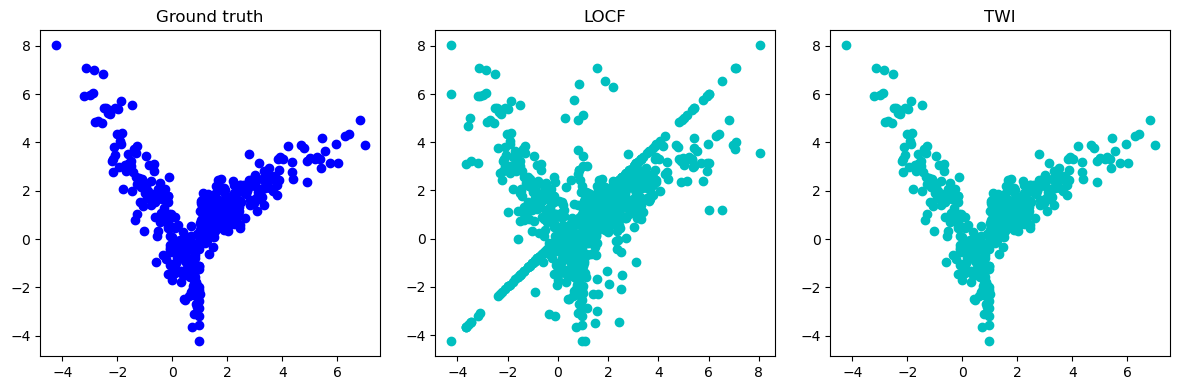

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].plot(x[:999], x[1:], 'bo')
axes[0].set_title('Ground truth')

axes[1].plot(x_init[:999], x_init[1:], 'co')
axes[1].set_title('LOCF')

axes[2].plot(x_imp[:999], x_imp[1:], 'co')
axes[2].set_title('TWI')

plt.tight_layout()
plt.show()

We see that TWI has significantly corrected the bias induced by the arbitrary LOCF imputation and its dynamics is more aligned with the underlying TAR process.

# 2 Multivariate time series with no side information

In this example, we consider that case where $\mathbf{x}_{t} = (x_{t,1}, x_{t,2})$ is a multivariate series (it can be more than 2-dimensional, of course).
The process follows a nonlinear VAR model:

\begin{align*}
    x_{t,1} &= 0.3 x_{t-1,1} + 8 \sigma(3x_{t-1,2}) + 0.25 \epsilon_{t,1} \\
    x_{t,2} &= 0.4 x_{t-1,2} + 3\epsilon_{t,2}
\end{align*}
where $\sigma(z) = 1 / (1 + \exp(-z)) - 0.5$ is the centered sigmoid function. 

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) - 0.5

x = np.zeros((1100, 2))
for i in range(1, 1100):
    x[i, 0] = 0.3 * x[i - 1, 0] + 8 * sigmoid(x[i - 1, 1]) + np.random.normal(size = 1, scale = 0.25)
    x[i, 1] = 0.4 * x[i - 1, 1] + np.random.normal(size = 1, scale = 3)
x = x[100:]

Again, we randomly omit 30\% of observations and use LOCF as initializations.
In this case, `WI_core_ordinary` and `solver_ordinary` can still be used.

In [21]:
x_obs = np.copy(x)
x_obs[np.random.choice(1000, size = 300, replace = False),:] = [None, None]

idx_obs = [i for i in range(1000) if ~np.isnan(x_obs[i, 0])]
idx_obs = [idx_obs, idx_obs]

x_init = np.copy(x_obs)
for i in range(1000):
    if i == 0:
        if np.isnan(x_init[i, 0]):
            x_init[i, 0] = x[i, 0] # just to avoid missing data in the first entry
            x_init[i, 1] = x[i, 1]
    if np.isnan(x_init[i, 0]):
        x_init[i,0] = x_init[i - 1,0] #LOCF
        x_init[i,1] = x_init[i - 1,1] #LOCF
        
x_imp = WI.WI_core_ordinary(x_obs, 400, p = 6, idx_obs = idx_obs, 
                            solver = WI.solver_ordinary, 
                            alpha = 40, WI_max_iter = 30)    

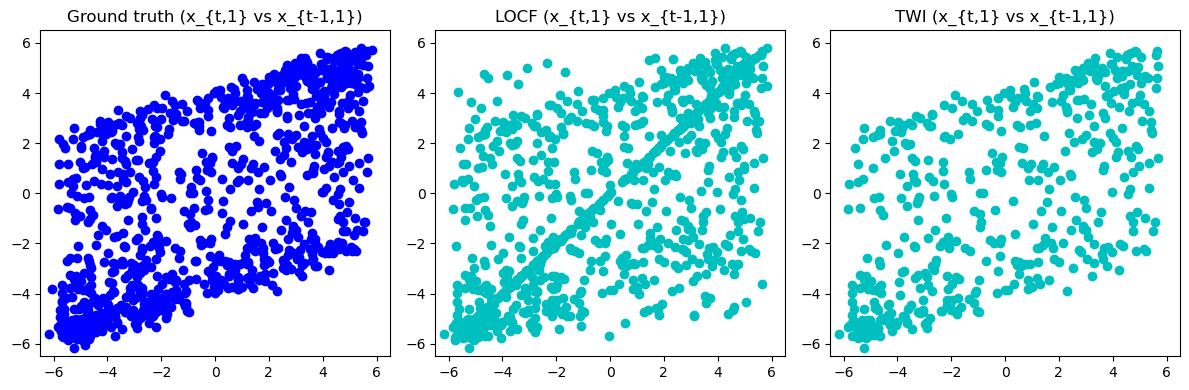

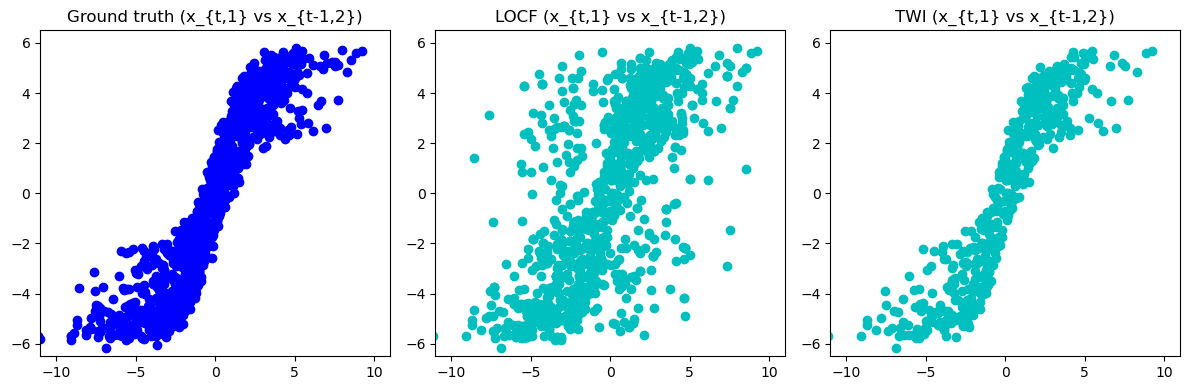

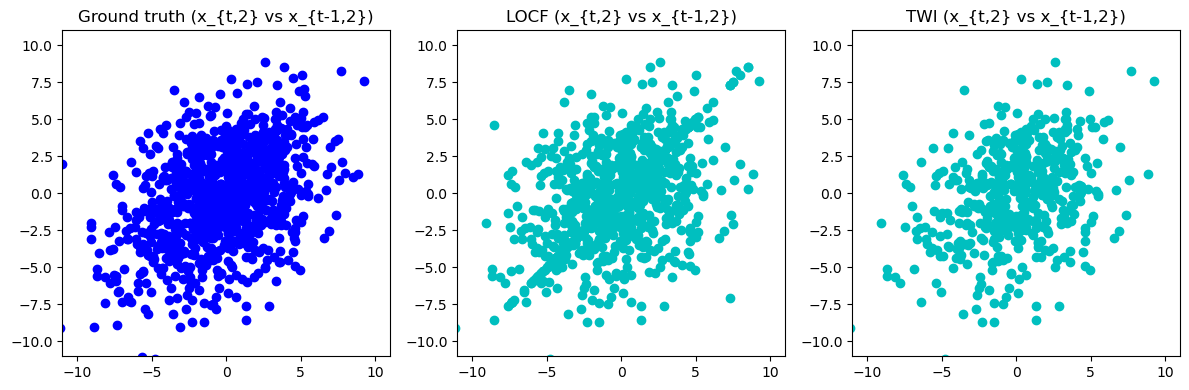

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].plot(x[:999,0], x[1:,0], 'bo')
axes[0].set_title('Ground truth (x_{t,1} vs x_{t-1,1})')
axes[0].set_xlim(-6.5, 6.5)
axes[0].set_ylim(-6.5, 6.5)

axes[1].plot(x_init[:999, 0], x_init[1:, 0], 'co')
axes[1].set_title('LOCF (x_{t,1} vs x_{t-1,1})')
axes[1].set_xlim(-6.5, 6.5)
axes[1].set_ylim(-6.5, 6.5)

axes[2].plot(x_imp[:999, 0], x_imp[1:, 0], 'co')
axes[2].set_title('TWI (x_{t,1} vs x_{t-1,1})')
axes[2].set_xlim(-6.5, 6.5)
axes[2].set_ylim(-6.5, 6.5)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].plot(x[:999,1], x[1:,0], 'bo')
axes[0].set_title('Ground truth (x_{t,1} vs x_{t-1,2})')
axes[0].set_xlim(-11, 11)
axes[0].set_ylim(-6.5, 6.5)

axes[1].plot(x_init[:999,1], x_init[1:, 0], 'co')
axes[1].set_title('LOCF (x_{t,1} vs x_{t-1,2})')
axes[1].set_xlim(-11, 11)
axes[1].set_ylim(-6.5, 6.5)

axes[2].plot(x_imp[:999,1], x_imp[1:, 0], 'co')
axes[2].set_title('TWI (x_{t,1} vs x_{t-1,2})')
axes[2].set_xlim(-11, 11)
axes[2].set_ylim(-6.5, 6.5)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].plot(x[:999,1], x[1:,1], 'bo')
axes[0].set_title('Ground truth (x_{t,2} vs x_{t-1,2})')
axes[0].set_xlim(-11, 11)
axes[0].set_ylim(-11, 11)

axes[1].plot(x_init[:999,1], x_init[1:,1], 'co')
axes[1].set_title('LOCF (x_{t,2} vs x_{t-1,2})')
axes[1].set_xlim(-11, 11)
axes[1].set_ylim(-11, 11)

axes[2].plot(x_imp[:999,1], x_imp[1:,1], 'co')
axes[2].set_title('TWI (x_{t,2} vs x_{t-1,2})')
axes[2].set_xlim(-11, 11)
axes[2].set_ylim(-11, 11)

plt.tight_layout()
plt.show()

Again, the above lag plots show TWI significantly corrects the biases induced by LOCF and the dynamics of the umputed series resembles the underlying nonlinear model.

# 3 Multivariate time series with side information

Here we consider multivariate time series, but we have side information about the missing entries. One such prominent example is the compositional time series $\mathbf{x}_{t} = (x_{t,1}, x_{t,2}, x_{t,3})$, which, for each $t$, satisfies $x_{t,1}+x_{t,2}+x_{t,3} = 1$.

The data are generated according to the Additive-logistic model:
\begin{align*}
    y_{t,1} =& 0.1 + 0.7 y_{t-1,1} - 0.5 y_{t-1,2} + 0.2 \epsilon_{t,1} \\
    y_{t,2} =& 0.1 - 0.7 y_{t-1,2} + 0.2 \epsilon_{t,2}
\end{align*}
and the observed data are
\begin{equation*}
    x_{t,j} = \left\{ \begin{aligned}
        &\frac{\exp(y_{t,j})}{1 + \exp(y_{t,1}) + \exp(y_{t,2})}, \quad j = 1, 2, \\
        &\frac{1}{1 + \exp(y_{t,1}) + \exp(y_{t,2})}, \quad j = 3.
    \end{aligned} \right. 
\end{equation*}

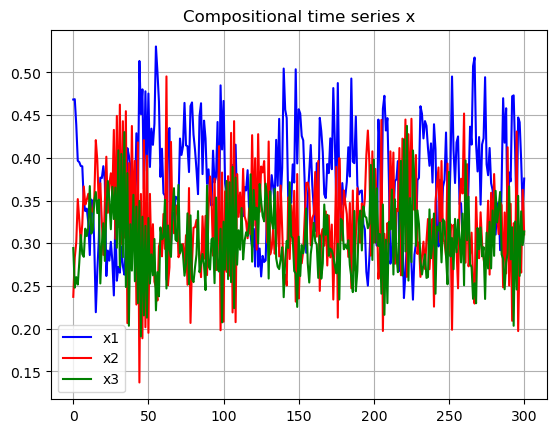

In [23]:
x = np.zeros((1100, 3))
y = np.zeros((1100, 2))
for i in range(4, 1100):
    y[i,0] = 0.1 + 0.7 * y[i - 1,0] - 0.5 * y[i - 1, 1] + np.random.normal(size = 1, scale = 0.2)
    y[i,1] = 0.1 - 0.7 * y[i - 1,1] + np.random.normal(size = 1, scale = 0.2)
    x[i,2] = 1 / (1 + np.sum(np.exp(y[i,:])))
    x[i,0] = x[i,2] * np.exp(y[i,0])
    x[i,1] = x[i,2] * np.exp(y[i,1])
x = x[100:]
y = y[100:]
    
plt.plot(np.linspace(0, 300, 301), x[:301,0], label='x1', color='blue')
plt.plot(np.linspace(0, 300, 301), x[:301,1], label='x2', color='red')
plt.plot(np.linspace(0, 300, 301), x[:301,2], label='x3', color='green')

plt.title('Compositional time series x')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.grid(True)
plt.show()

We want to utilize the information that the sum of $x$ at each time point is unity. This information can be encoded via a linear constraint. Specifically, suppose $\mathbf{x}_{1}$ is observed but $\mathbf{x}_{2}$ is missing, then the imputation $\mathbf{W}$ must satisfy

\begin{align*}
    \underbrace{
    \begin{pmatrix}
        1 & 0 & \ldots & 0 & 0 & \ldots & 0 & 0 & \ldots \\
        0 & 0 & \ldots & 1 & 0 & \ldots & 0 & 0 & \ldots \\
        0 & 0 & \ldots & 0 & 0 & \ldots & 1 & 0 & \ldots \\
        0 & 1 & \ldots & 0 & 1 & \ldots & 0 & 1 & \ldots \\
        \vdots & \ddots & \ddots &&&&&&
    \end{pmatrix}}_{\mathbf{K}}
    \begin{pmatrix}
        w_{1,1} \\
        w_{2,1} \\
        \vdots  \\
        w_{1,2} \\
        w_{2,2} \\
        \vdots  \\
        w_{3,1} \\
        w_{3,2} \\
        \vdots
    \end{pmatrix} = 
    \underbrace{
    \begin{pmatrix}
        x_{1,1} \\
        x_{1,2} \\
        x_{1,3} \\
        1 \\
        \vdots
    \end{pmatrix}}_{\mathbf{b}}
\end{align*}


In such cases (missing information can be encoded in linear constraints), use `WI_core_exact` which is specifically designed for this scenario. It does not implement the proximal gradient descent but rather computes step (b) in the alternating minimization using the closed-form solution in Huang et al. (2025) Hence the user does not need to supply a solver. `WI_core_exact` has the following arguments.

- `x`: $(n, d)$ array of time series with missing values initialized
- `n1`: cut-off point for TWI
- `p`: dimension of the marginal distribution to match
- `K`, `b`: parameters defining the admissible set (see above)
- `Lambda`: regularization parameter; default is zero
- `WI_max_iter`: maximum number of iterations. Default is 1000
- `WI_tol`: optimization tolerance. Default is 1e-4
- `verbose`: whether to print information along iterations. Default is False

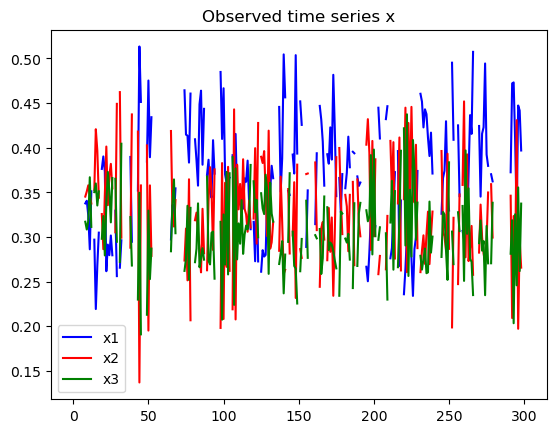

In [24]:
x_obs = np.copy(x)
x_obs[np.random.choice(1000, size = 300, replace = False),:] = [None, None, None]

idx_obs = [i for i in range(1000) if ~np.isnan(x_obs[i, 0])]
idx_obs = [idx_obs, idx_obs, idx_obs]

x_init = np.copy(x_obs)
for i in range(1000):
    if i == 0:
        if np.isnan(x_init[i, 0]):
            x_init[i, 0] = x[i, 0] # just to avoid missing data in the first entry
            x_init[i, 1] = x[i, 1]
            x_init[i, 2] = x[i, 2]
    if np.isnan(x_init[i, 0]):
        x_init[i,0] = x_init[i - 1,0] #LOCF
        x_init[i,1] = x_init[i - 1,1] #LOCF
        x_init[i,2] = x_init[i - 1,2] #LOCF

plt.plot(np.linspace(0, 300, 301), x_obs[:301,0], label='x1', color='blue')
plt.plot(np.linspace(0, 300, 301), x_obs[:301,1], label='x2', color='red')
plt.plot(np.linspace(0, 300, 301), x_obs[:301,2], label='x3', color='green')

plt.title('Observed time series x')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

Next we show how to use `WI_core_exact` with $\mathbf{K}$ and $\mathbf{b}$.

In [25]:
K = np.zeros((len(idx_obs[0]) * 3 + (1000 - len(idx_obs[0])), 3 * 1000))
b = np.zeros((len(idx_obs[0]) * 3 + (1000 - len(idx_obs[0])), 1))
counter = 0
for i in range(1000):
    if i in idx_obs[0]:
        for j in range(3):
            K[counter, i + j * 1000] = 1
            b[counter, 0] = x_obs[i,j]
            counter += 1
    else:
        for j in range(3):
            K[counter, i + (j * 1000)] = 1
        b[counter, 0] = 1
        counter += 1            
    
x_imp = WI.WI_core_exact(np.copy(x_init), 400, 6, K, b, Lambda = 1e-4, WI_max_iter = 10, WI_tol = 1e-4)

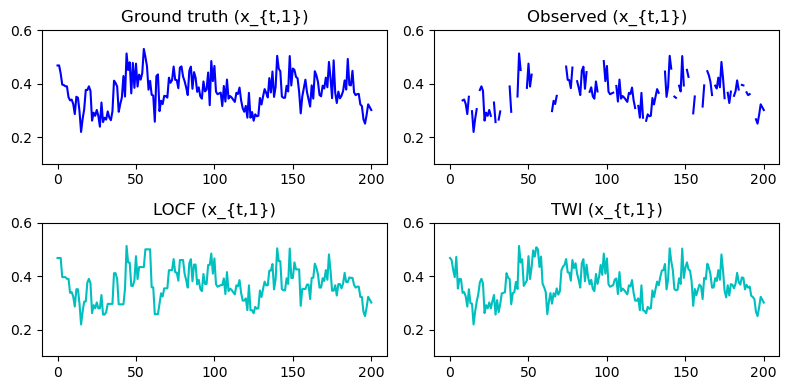

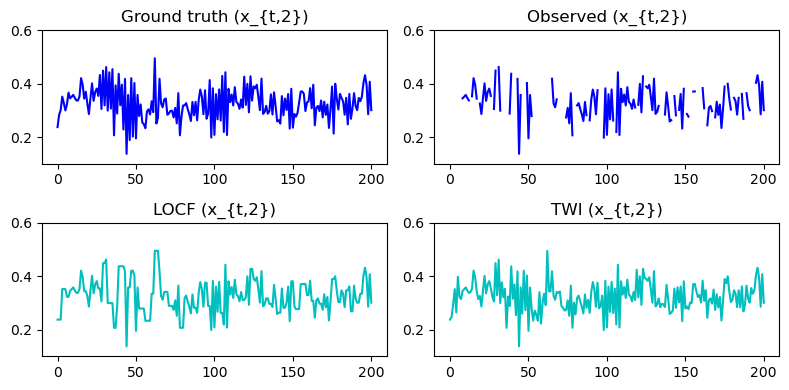

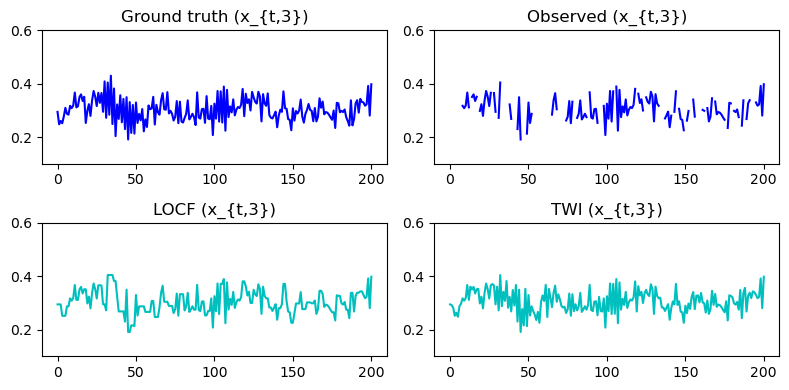

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4)) 

axes[0,0].plot(x[:201,0], 'blue')
axes[0,0].set_title('Ground truth (x_{t,1})')
axes[0,0].set_ylim(0.1, 0.6)

axes[0,1].plot(x_obs[:201,0], 'blue')
axes[0,1].set_title('Observed (x_{t,1})')
axes[0,1].set_ylim(0.1, 0.6)

axes[1,0].plot(x_init[:201,0], 'c-')
axes[1,0].set_title('LOCF (x_{t,1})')
axes[1,0].set_ylim(0.1, 0.6)

axes[1,1].plot(x_imp[:201,0], 'c-')
axes[1,1].set_title('TWI (x_{t,1})')
axes[1,1].set_ylim(0.1, 0.6)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 4)) 

axes[0,0].plot(x[:201,1], 'blue')
axes[0,0].set_title('Ground truth (x_{t,2})')
axes[0,0].set_ylim(0.1, 0.6)

axes[0,1].plot(x_obs[:201,1], 'blue')
axes[0,1].set_title('Observed (x_{t,2})')
axes[0,1].set_ylim(0.1, 0.6)

axes[1,0].plot(x_init[:201,1], 'c-')
axes[1,0].set_title('LOCF (x_{t,2})')
axes[1,0].set_ylim(0.1, 0.6)

axes[1,1].plot(x_imp[:201,1], 'c-')
axes[1,1].set_title('TWI (x_{t,2})')
axes[1,1].set_ylim(0.1, 0.6)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 4)) 

axes[0,0].plot(x[:201,2], 'blue')
axes[0,0].set_title('Ground truth (x_{t,3})')
axes[0,0].set_ylim(0.1, 0.6)

axes[0,1].plot(x_obs[:201,2], 'blue')
axes[0,1].set_title('Observed (x_{t,3})')
axes[0,1].set_ylim(0.1, 0.6)

axes[1,0].plot(x_init[:201,2], 'c-')
axes[1,0].set_title('LOCF (x_{t,3})')
axes[1,0].set_ylim(0.1, 0.6)

axes[1,1].plot(x_imp[:201,2], 'c-')
axes[1,1].set_title('TWI (x_{t,3})')
axes[1,1].set_ylim(0.1, 0.6)

plt.tight_layout()
plt.show()

This again confirms that TWI provides substantial improvement from the LOCF initialization.